In [1]:
import giraffe
from netZooPy.otter.otter import otter
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import torch
from data.yeast import preprocessing

In [20]:
preprocessing = True

In [21]:
if not preprocessing:
    preprocessing.generate_data()

In [3]:
expression = pd.read_csv("data/yeast/raw/YeastCCData_Expression.txt", sep = '\t', header = None).iloc[:, 1:]
motif_edge_list = pd.read_csv("data/yeast/motif_edge_list.txt", index_col = 0)
motif_matrix = pd.read_csv("data/yeast/motif_matrix.txt", index_col = 0)
ppi = pd.read_csv("data/yeast/ppi.txt", index_col = 0)

## Validation

In [4]:
def get_ground_truth_and_estimation(estimated_regulation):
    
    chip = pd.read_csv("data/yeast/raw/YeastCCData_ChIP.txt", sep = '\t', header = None)
    chip[chip[0] == "SIG1"] = "YER068W"
    chip[chip[0] == "RCS1"] = "YGL071W"
    chip[chip[0] == "RLR1"] = "YNL139C"
    chip[3] = 0
    
    to_drop = []
    for i in range(chip.shape[0]) :
            if (not type(chip[2].iloc[i]) == float):
                to_drop += [i] 
                continue
            if np.isnan(chip[2].iloc[i]) :
                continue
            if chip[2].iloc[i] >= 0.001 :
                chip[2].iloc[i] = 0
            else :
                chip[2].iloc[i] = 1
            chip[3].iloc[i] = estimated_regulation[chip[0].iloc[i]][chip[1].iloc[i]]
    
    chip = chip.drop(to_drop)
    chip = chip.dropna(axis = 0)     
    
    return chip[2].values.astype(int), chip[3].values

## GIRAFFE

In [5]:
giraffe_regulation = giraffe.Giraffe(expression, motif_matrix.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), lr = 1e-6).get_regulation()

In [6]:
ground_truth, pred_giraffe = get_ground_truth_and_estimation(pd.DataFrame(np.abs(giraffe_regulation), index = motif_matrix.index, columns = motif_matrix.columns))

## Baseline 1: OTTER

In [15]:
R_otter = otter(motif_matrix.T.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), np.corrcoef(expression.to_numpy()))

In [16]:
ground_truth, pred_otter = get_ground_truth_and_estimation(pd.DataFrame(np.abs(R_otter.T), index = motif_matrix.index, columns = motif_matrix.columns))

## Baseline 2: PANDA

In [11]:
panda_regulation = giraffe.compute_panda_locally(expression.to_numpy(), motif_matrix.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]))

Loading motif data ...
  Elapsed time: 0.02 sec.
Loading PPI data ...
Number of PPIs: 205
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.10 sec.
Creating motif network ...
  Elapsed time: 0.06 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt             0         1         2         3         4         5         6   \
0    -0.454998 -0.309194 -0.262303 -0.421252 -0.197629 -0.307669 -0.353565   
1    -0.597662 -0.320284 -0.536667 -0.689599 -0.414873 -0.577489 -0.817900   
2     0.087725  0.550268  0.848826  0.273479  0.076695 -0.189383 -0.173207   
3    -0.113569  0.164949  0.361346  0.162160  0.225401  0.099997  0.067658   
4     0.259242  0.051613  0.028684 -0.119949 -0.322407 -0.423545 -0.466035   
...        ...       ...       ...       ...       ...       ...       ...   
3546 -0.124560 -0.098976  0.123657  0.159412  0.202342  0.362248  0.447583   
3547 -0.311494 -0.313270 -0.244329  0.268955  0.118470 -0.138542  0.15879

In [12]:
ground_truth, pred_panda = get_ground_truth_and_estimation(pd.DataFrame(panda_regulation, index = motif_matrix.index, columns = motif_matrix.columns))

## Motif

In [18]:
ground_truth, pred_motif = get_ground_truth_and_estimation(pd.DataFrame(motif_matrix, index = motif_matrix.index, columns = motif_matrix.columns))

## Plots

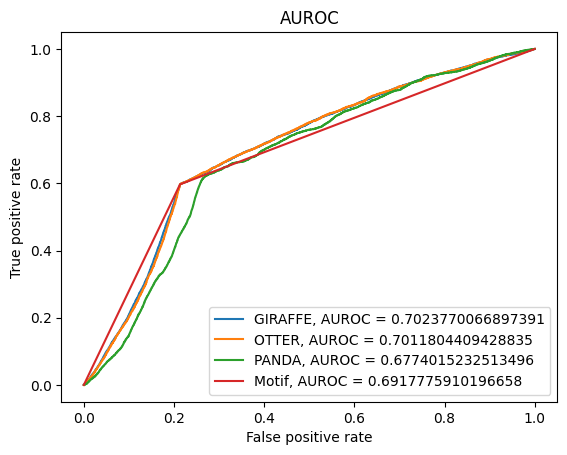

[0.7023770066897391,
 0.7011804409428835,
 0.6774015232513496,
 0.6917775910196658]

In [19]:
giraffe.utils.plot_auroc(ground_truth, 
                         [pred_giraffe, pred_otter, pred_panda, pred_motif], 
                         ["GIRAFFE", "OTTER", "PANDA", "Motif"]
                        )

## References

[1] Glass K, Huttenhower C, Quackenbush J, Yuan GC. "Passing Messages Between Biological Networks to Refine Predicted Interactions", PLoS One, 2013 May 31;8(5):e64832

[2] Weighill, Deborah, et al. "Gene regulatory network inference as relaxed graph matching." Proceedings of the... AAAI Conference on Artificial Intelligence. AAAI Conference on Artificial Intelligence. Vol. 35. No. 11. NIH Public Access, 2021.